### Data Augmentation and Transfer Learning

In [1]:
# mount Google Drive to the Colab Virtual Machine
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

### Download dataset across Kaggle

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/urban-and-rural-photos")

print("Path to dataset files:", path)

100%|██████████| 6.15M/6.15M [00:00<00:00, 25.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/urban-and-rural-photos/versions/2


In [5]:
# See what there is in the folder
import os
os.listdir(path + '/rural_and_urban_photos/train/urban')[0]

'urban_37.jpg'

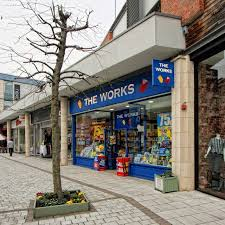

In [6]:
# Show an image
load_img(path + '/rural_and_urban_photos/train/urban/urban_21.jpeg')

In [13]:
print("Number of images with label 'urban' for train: ", len(os.listdir(path + '/rural_and_urban_photos/train/urban')))
print("Number of images with label 'rural'for train: ", len(os.listdir(path + '/rural_and_urban_photos/train/rural')))

Number of images with label 'urban' for train:  36
Number of images with label 'rural'for train:  36


In [8]:
os.listdir(path + '/rural_and_urban_photos')

['train', 'val']

In [14]:
print("Number of images with label 'urban' for test: ", len(os.listdir(path + '/rural_and_urban_photos/val/urban')))
print("Number of images with label 'rural' for test: ", len(os.listdir(path + '/rural_and_urban_photos/val/rural')))

Number of images with label 'urban' for test:  10
Number of images with label 'rural' for test:  10


In [38]:
# Load images (for train) across ImageDataGenerator (method flow_from_directory)
train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)   # Apply preprocessing
xtrain, ytrain = next(train_datagen.flow_from_directory(path + '/rural_and_urban_photos/train', target_size=(224, 224), batch_size=72))

Found 72 images belonging to 2 classes.


In [40]:
xtrain.shape

(72, 224, 224, 3)

In [42]:
ytrain.shape

(72, 2)

In [34]:
# Load images (for test) across ImageDataGenerator (method flow_from_directory)
test_datagen = ImageDataGenerator()
raw_xtest, ytest = next(test_datagen.flow_from_directory(path + '/rural_and_urban_photos/val', target_size=(224, 224), batch_size=20))
xtest = resnet50.preprocess_input(raw_xtest)

Found 20 images belonging to 2 classes.


### Create the model

In [24]:
# Create the model deleting the last levels
base_model = ResNet50(weights="imagenet", include_top=False)

In [25]:
len(base_model.layers)

175

In [17]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
# Add other layers into the model for solve our task

# Model Trained
old_model = base_model.output
# Add the GlobalAveragePooling2D layer to transform the object in one dimensional
new_model = GlobalAveragePooling2D() (old_model)
# Add Fully connected layers
new_model = Dense(1024, activation="relu", name='my_layer_1') (new_model)
new_model = Dense(512, activation="relu", name='my_layer_2') (new_model)
new_model = Dense(2, activation="softmax", name='my_layer_3') (new_model)

# Link the model trained with news layers
transfer_model = Model(inputs=base_model.input, outputs=new_model)

In [27]:
# Apply freezing for layers in the model trained
for layer in transfer_model.layers[:174]:
  layer.trainable = False
for layer in transfer_model.layers[174:]:
  layer.trainable = True

In [28]:
# Compile the model
transfer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Training

In [43]:
history = transfer_model.fit(xtrain, ytrain, batch_size=32, epochs=5, validation_data=(xtest, ytest))

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - accuracy: 0.7465 - loss: 0.4619 - val_accuracy: 1.0000 - val_loss: 0.0132
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.9000 - val_loss: 0.5602
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.9783 - loss: 0.0859 - val_accuracy: 0.9500 - val_loss: 0.1471
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9596 - loss: 0.1165 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 1.0000 - loss: 4.6049e-09 - val_accuracy: 0.9000 - val_loss: 1.4248


In [44]:
transfer_model.evaluate(xtest, ytest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9000 - loss: 1.4248


[1.424785852432251, 0.8999999761581421]

### Visualization

In [47]:
# Save the predictions
predictions = transfer_model.predict(xtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [48]:
predictions.shape

(20, 2)

In [51]:
target_class = ["rural", "urban"]

In [52]:
ytest

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [54]:
np.set_printoptions(suppress=True) # Suppress Scientific Notation
predictions

array([[0.00014855, 0.99985147],
       [0.        , 0.99999994],
       [0.99999994, 0.        ],
       [0.        , 0.99999994],
       [0.        , 0.99999994],
       [0.9989501 , 0.00104983],
       [0.        , 0.99999994],
       [0.        , 0.99999994],
       [0.99999994, 0.        ],
       [0.        , 0.99999994],
       [0.        , 0.99999994],
       [0.99999994, 0.        ],
       [0.99989384, 0.00010607],
       [0.99999994, 0.        ],
       [0.        , 0.99999994],
       [0.        , 0.99999994],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ]], dtype=float32)

In [57]:
str_predictions = np.array(["rural", "urban"]) [np.argmax(predictions, axis=1)]
str_predictions

array(['urban', 'urban', 'rural', 'urban', 'urban', 'rural', 'urban',
       'urban', 'rural', 'urban', 'urban', 'rural', 'rural', 'rural',
       'urban', 'urban', 'urban', 'rural', 'urban', 'rural'], dtype='<U5')

In [73]:
# Count the frequency of each value
unique, frequency = np.unique(str_predictions, return_counts = True)
print("Unique Values:", unique)
print("Frequency Values:", frequency)

Unique Values: ['rural' 'urban']
Frequency Values: [ 8 12]


In [67]:
# Show all test images with true target and predict target
plt.figure(figsize=(20, 16))
for k in range (20):
  plt.subplot(4, 5, k+1)
  plt.imshow(array_to_img(raw_xtest[k]))       # Show each image
  predict_target = str_predictions[k]      # predicted target
  true_target = target_class[np.argmax(ytest[k])]  # true target
  plt.title(true_target, fontsize=20, color = "black" if predict_target == true_target else "red" )  # If the value is different apply color red
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [66]:
# The model has wrong these two images
print(ytest[0], ytest[15])
print(predictions[0], predictions[15])

[1. 0.] [1. 0.]
[0.00014855 0.99985147] [0.         0.99999994]
